In [1]:
from __future__ import print_function
import matplotlib
%matplotlib inline
import torch
import numpy as np
SEED=123
_=np.random.seed(SEED)
_=torch.manual_seed(SEED)

In [2]:
![ -d kmi ] || git clone https://github.com/drinkingkazu/kmi
! cd kmi && git pull

Already up to date.


In [3]:
from kmi.iotools import loader_factory

# Here's loader_factory arguments
loader_config = dict( data_files = ['/scratch/workshop_2020_01/train/eminus.h5',
                                    '/scratch/workshop_2020_01/train/muon.h5',
                                    '/scratch/workshop_2020_01/train/gamma.h5',
                                    '/scratch/workshop_2020_01/train/proton.h5'],                                    
                      dataset = 'DenseImage2D',
                      collate = 'DenseCollate',
                      batch_size = 64,
                      shuffle = True,
                      num_workers = 4,
                      pdg_list = [11,13,22,2212],
                    )

# Create a loader
loader = loader_factory(**loader_config)

# Create an iterator for playin in this notebook
from itertools import cycle
iter = cycle(loader)


In [4]:
class CNN(torch.nn.Module):
    def __init__(self):
        
        super(CNN, self).__init__()
        # feature extractor CNN
        self._feature_extractor = torch.nn.Sequential(
            torch.nn.Conv2d(1,32,3,padding=1), torch.nn.BatchNorm2d(32,momentum=0.9),            
            torch.nn.ReLU(),
            torch.nn.Conv2d(32,32,3,padding=1), torch.nn.BatchNorm2d(32,momentum=0.9),
            torch.nn.ReLU(),            
            torch.nn.Conv2d(32,64,3,2,padding=1), torch.nn.BatchNorm2d(64,momentum=0.9),            
            torch.nn.ReLU(),
            torch.nn.Conv2d(64,64,3,padding=1), torch.nn.BatchNorm2d(64,momentum=0.9),
            torch.nn.ReLU(),            
            torch.nn.Conv2d(64,128,3,2,padding=1), torch.nn.BatchNorm2d(128,momentum=0.9),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,128,3,padding=1), torch.nn.BatchNorm2d(128,momentum=0.9),
            torch.nn.ReLU(),            
            torch.nn.Conv2d(128,256,3,2,padding=1), torch.nn.BatchNorm2d(256,momentum=0.9),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256,256,3,padding=1), torch.nn.BatchNorm2d(256,momentum=0.9),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256,512,3,2,padding=1), torch.nn.BatchNorm2d(512,momentum=0.9),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512,512,3,padding=1), torch.nn.BatchNorm2d(512,momentum=0.9),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(12,12))
        # classifier MLP
        self._classifier = torch.nn.Linear(512,4)

    def forward(self, x):
        # extract features
        features = self._feature_extractor(x)
        # flatten the 3d tensor (2d space x channels = features)
        features = features.view(-1, np.prod(features.size()[1:]))
        # classifier
        return self._classifier(features)

In [5]:
class BLOB:
    pass
blob=BLOB()
blob.net       = CNN().cuda() # construct Lenet, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.iteration = 0    # integer count for the number of train steps
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

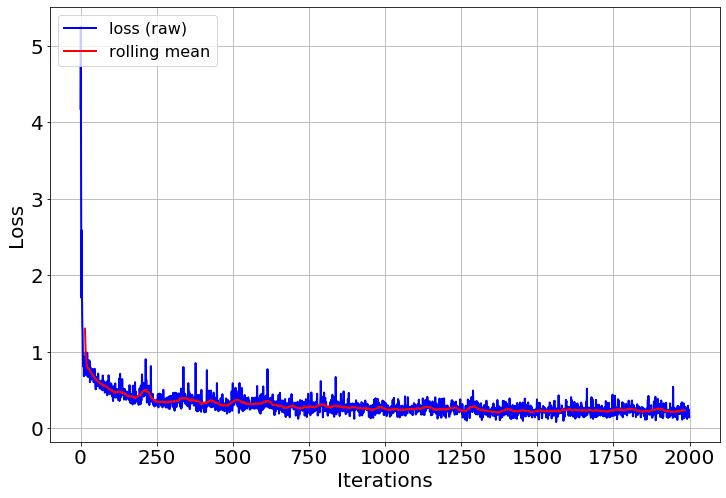

In [6]:
# Import train_loop, plot_loss
from kmi.utils import train_loop, plot_loss, save_state
# Train
plot_loss(train_loop(blob,loader,num_iteration=2000))
# Save
blob.weight_file=save_state(blob,prefix='./PID')

Train set accuracy mean 0.9031559405940595 std 0.0389009532049524


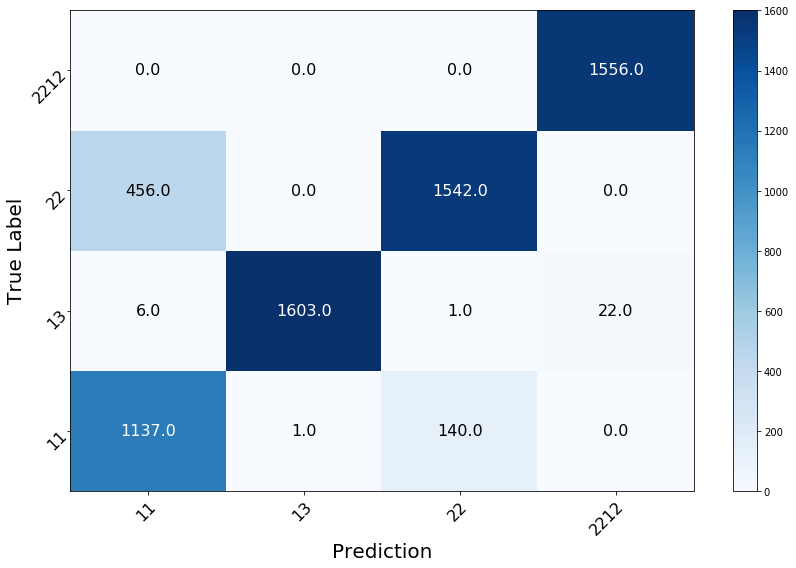

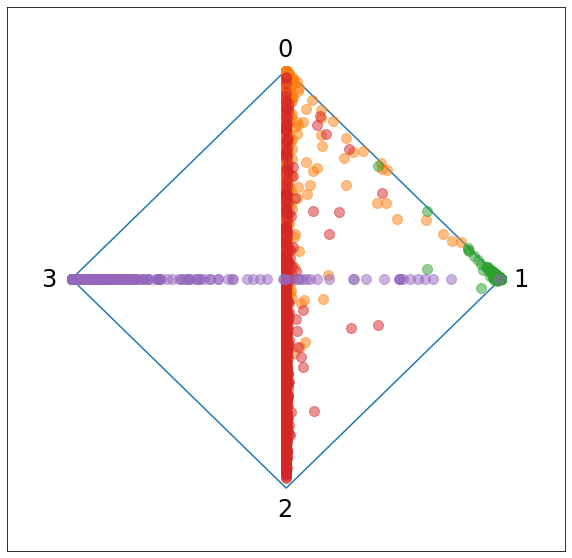

In [7]:
# For plotting a confusion matrix
from kmi.utils import inference_loop, plot_confusion_matrix, plot_softmax, restore_state

# Re-load the state if the weight_file is provided
if hasattr(blob,'weight_file') and blob.weight_file:
    restore_state(blob)

# For the Train set
accuracy, label, prediction, softmax = inference_loop(blob,loader,'./',100)
print("Train set accuracy mean",accuracy.mean(),"std",accuracy.std())
plot_confusion_matrix(label,prediction,[11,13,22,2212])
plot_softmax(label,softmax)

